In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
import pickle
import numpy as np
from typing import Tuple
from fastcore.test import test_eq
from math import sqrt

from multiprocessing.pool import ThreadPool as Pool

import sklearn

from cupid_matching.matching_utils import Matching, _get_singles
from cupid_matching.model_classes import ChooSiowPrimitives
from cupid_matching.entropy import EntropyFunctions
from cupid_matching.choo_siow import entropy_choo_siow
from cupid_matching.min_distance import estimate_semilinear_mde, \
    MDEResults
from cupid_matching.poisson_glm import choo_siow_poisson_glm, \
    PoissonGLMResults

from matching_separable_simuls.utils import get_root_dir, nprepeat_col, nprepeat_row
from matching_separable_simuls.read_data import read_margins, read_marriages, \
    rescale_mus, reshape_varcov, remove_zero_cells
from matching_separable_simuls.estimate import generate_bases
from matching_separable_simuls.plots import plot_simulation_results

# matching_separable_simuls

> Simulations for Galichon-Salanie paper on estimating separable matching models

## Install

```sh
pip install matching_separable_simuls
```

## summary

The package reads the marriage patterns from the Choo and Siow 2006 *Journal of Political Economy* paper for the non-reform states of the  1970 wave. It fits a parsimonious homoskedastic logit model. Then it generates `n_sim` datasets from the fitted model, and it uses them to test the estimation methods presented in Galichon-Salanié 2022.

## setting the options

In [ ]:
do_simuls = False
plot_simuls = False

# model_name = "choo_siow_firstsub"
model_name = "choo_siow_cupid"
# model_name = "choo_siow_firstsub10"

n_households_cupid_pop = 13_274_041    # number of households in the Cupid population
n_households_cupid_obs = 75_265        # number of households in the Cupid sample 
n_households_sim = n_households_cupid_obs           # number of households in the simulation
n_sim = 100                            # number of simulations
value_coeff = 1.0                     # we set the zeros at the smallest positive value divided by value_coeff

## using the Cupid/Choo and Siow data

In [ ]:
#| echo: false
data_dir = get_root_dir() / "matching_separable_simuls" / "ChooSiow70nNdata"

First, we read the Choo and Siow 1970 non-reform data used in Cupid.

### reading and prepping the data

In [ ]:
#| echo: false
if model_name == "choo_siow_cupid":
    nx, my = read_margins(data_dir)
    muxy, varmus = read_marriages(data_dir)
    n_types_men, n_types_women = muxy.shape
    mux0, mu0y = _get_singles(muxy, nx, my)
    print(f"\nThe data has {n_types_men} types of men and {n_types_women} types of women.")


The data has 25 types of men and 25 types of women.


In [ ]:
#| hide
if model_name == "choo_siow_cupid":
    test_eq(muxy[3,4], 16730.0)
    test_eq(nx[-1], 84399)
    test_eq(my[7], 281192)
    test_eq(varmus.shape, (675, 675))

We rescale the matching and we reshape and rescale the covariance matrix.

In [ ]:
#| echo: true
if model_name == "choo_siow_cupid":
    mus = Matching(muxy, nx, my)
    mus_norm = rescale_mus(mus, n_households_cupid_obs)

    varmus_norm = reshape_varcov(varmus, mus, n_households_cupid_obs)

In [ ]:
#| echo: true
if model_name == "choo_siow_cupid":
    mus = Matching(muxy, nx, my)
    mus_norm = rescale_mus(mus, n_households_cupid_obs)

    varmus_norm = reshape_varcov(varmus, mus, n_households_cupid_obs)

Finally, we add a small number to zero cells to make them non-empty:

In [ ]:
if model_name == "choo_siow_cupid":
    mus_norm_fixed = remove_zero_cells(mus_norm, coeff=value_coeff) 
    muxy_norm_fixed, mux0_norm_fixed, mu0y_norm_fixed, nx_norm_fixed, my_norm_fixed = mus_norm_fixed.unpack()

### setting up a basic model

We need to generate some basis functions. First we quantile-transform the margins; then we generate orthogonal polynomials on `[0,1]`.   Our first three base functions are `1`,   `1(x>y)`, and `max(x-y, 0)` (rescaled). Then  we specify monomials $x^a y^b$ in the `degrees` list.

In [ ]:
if model_name == "choo_siow_cupid":
    degrees = [(1,0), (0,1), (2,0), (1,1), (0,2)]
    base_functions, base_names = generate_bases(nx_norm_fixed, my_norm_fixed, degrees)
    n_bases = base_functions.shape[-1]
    print(f"We created {n_bases} bases:")
    print(f"{base_names}")

We created 8 bases:
['1', '1(x>y)', 'max(x-y,0)', 'x^1 * y^0', 'x^0 * y^1', 'x^2 * y^0', 'x^1 * y^1', 'x^0 * y^2']


### we save the data and the bases we generated

In [ ]:
if model_name == "choo_siow_cupid":
    with open(data_dir / f"{model_name}_mus_norm_fixed_{int(value_coeff)}.pkl", "wb") as f:
        pickle.dump(mus_norm_fixed, f)
    with open(data_dir / f"{model_name}_varmus_norm.pkl", "wb") as f:
        pickle.dump(varmus_norm, f)
    with open(data_dir / f"{model_name}_base_functions.pkl", "wb") as f:
        pickle.dump(base_functions, f)

### testing the estimation

In [ ]:
if model_name == "choo_siow_cupid":
    mde_results = estimate_semilinear_mde(
        mus_norm_fixed, base_functions, entropy_choo_siow, 
        more_params=None
    )

    estim_Phi = mde_results.estimated_Phi
    estim_coeffs = mde_results.estimated_coefficients
    varcov_coeffs = mde_results.varcov_coefficients
    std_coeffs = mde_results.stderrs_coefficients

    print(mde_results)
    
    with open(data_dir / f"{model_name}_mde_results.pkl", "wb") as f:
        pickle.dump(mde_results, f)

********************************************************************************
The data has 75264.82360878828 households

The model has 25x25 margins
      The entropy is parameter-free. 
We use 8 basis functions.

The estimated coefficients (and their standard errors) are

   base 1:     -8.405 ( 0.114)
   base 2:      1.355 ( 0.064)
   base 3:    -17.184 ( 0.576)
   base 4:     -4.236 ( 0.187)
   base 5:      5.981 ( 0.166)
   base 6:     -1.731 ( 0.112)
   base 7:      2.620 ( 0.305)
   base 8:     -0.836 ( 0.139)

Specification test:
   the value of the test statistic is   2171.279
     for a chi2(617), the p-value is      0.000
********************************************************************************



## generating artificial datasets and fitting a homoskedastic logit model

In [ ]:
if model_name == "choo_siow_cupid":           # we use the Phi and the margins we got from the Cupid dataset
    choo_siow_estim = ChooSiowPrimitives(estim_Phi, nx_norm_fixed, my_norm_fixed)
elif model_name.startswith("choo_siow_firstsub"):      # we regenerate the simulation in the first submitted version
    n_types_men = n_types_women = 20
    theta1 = np.array([1.0, 0.0, 0.0, -0.01, 0.02, -0.01, 0.5, 0.0])
    if model_name == "choo_siow_firstsub10":
        theta1 *= 10
    n_bases = theta1.size
    base_functions = np.zeros((n_types_men, n_types_women, n_bases))
    base_functions[:, :, 0] = 1.0
    vec_x = np.arange(n_types_men)
    vec_y = np.arange(n_types_women)
    base_functions[:, :, 1] = nprepeat_col(vec_x, n_types_women)
    base_functions[:, :, 2] = nprepeat_row(vec_y, n_types_men)
    base_functions[:, :, 3] = base_functions[:, :, 1] * base_functions[:, :, 1]
    base_functions[:, :, 4] = base_functions[:, :, 1] * base_functions[:, :, 2]
    base_functions[:, :, 5] = base_functions[:, :, 2] * base_functions[:, :, 2]
    for i in range(n_types_men):
        for j in range(i, n_types_women):
            base_functions[i, j, 6] = 1
            base_functions[i, j, 7] = i - j
    base_names = ["1", "x", "y", "x^2", "xy", "y^2", "1(x>y)", "max(x-y,0)"]
    Phi1 = base_functions @ theta1
    t = 0.2
    nx1 = np.logspace(start=0, base=1 - t, stop=n_types_men - 1, num=n_types_men)
    my1 = np.logspace(start=0, base=1 - t, stop=n_types_women - 1, num=n_types_women)
    choo_siow_estim = ChooSiowPrimitives(Phi1, nx1, my1)
    estim_coeffs = theta1


def _run_simul(
    i_sim: int,            # the index of the simulation
    seed: int,             # the seed for its random draws 
    n_households_sim: float, # the number of households in the simulation
    base_functions: np.ndarray,   # the bases
    entropy: EntropyFunctions,  # the entropy 
    value_coeff: float          # the divider
    ) ->  Tuple[MDEResults, PoissonGLMResults]:
    """ runs one simulation for both estmators"""
    mus_sim = choo_siow_estim.simulate(n_households_sim, seed=seed)
    mus_sim_non0 = remove_zero_cells(mus_sim, coeff=value_coeff)
    mde_results_sim = estimate_semilinear_mde(
        mus_sim_non0, base_functions, entropy, more_params=None)
    estim_coeffs_mde = mde_results_sim.estimated_coefficients
    poisson_results_sim = choo_siow_poisson_glm(mus_sim_non0, base_functions, verbose = 0)
    estim_coeffs_poisson = poisson_results_sim.estimated_beta
    if i_sim % 10 == 0:
        print(f"Done simul {i_sim}")
    return estim_coeffs_mde, estim_coeffs_poisson


In [ ]:
if do_simuls:
    
    # generate random seeds
    rng = np.random.default_rng(130962)
    seeds = rng.integers(100_000, size=n_sim)

    estim_coeffs_mde = np.zeros((n_sim, n_bases))
    estim_coeffs_poisson = np.zeros((n_sim, n_bases))

    list_args = [
        [
            i_sim, seeds[i_sim], n_households_sim, 
            base_functions, entropy_choo_siow, value_coeff
        ] for i_sim in range(n_sim)
    ]

    nb_cpus = 8

    with Pool(nb_cpus) as pool:
        results = pool.starmap(_run_simul, list_args)

    for i_sim in range(n_sim):
        estim_coeffs_mde[i_sim, :] = results[i_sim][0]
        estim_coeffs_poisson[i_sim, :] = results[i_sim][1]

    simul_results = {'Base names': base_names, 'Base functions': base_functions,
                     'True coeffs': estim_coeffs,
                     'MDE': estim_coeffs_mde, 'Poisson': estim_coeffs_poisson}
    
    if model_name == "choo_siow_cupid":
        simul_results['MDE stderrs'] = std_coeffs
        simul_results['MDE varcov'] = varcov_coeffs

    with open(data_dir / f"{model_name}_{n_households_sim}_{int(value_coeff)}.pkl", "wb") as f:
        pickle.dump(simul_results, f)



Done simul 0
Done simul 20
Done simul 30
Done simul 10
Done simul 40
Done simul 60
Done simul 50
Done simul 70
Done simul 80
Done simul 90


### we plot the distributions of the estimates

We have a total of 0 outliers for MDE,  out of 100 simulations.
We have a total of 0 outliers for Poisson,  out of 100 simulations.
We have found no outlier samples


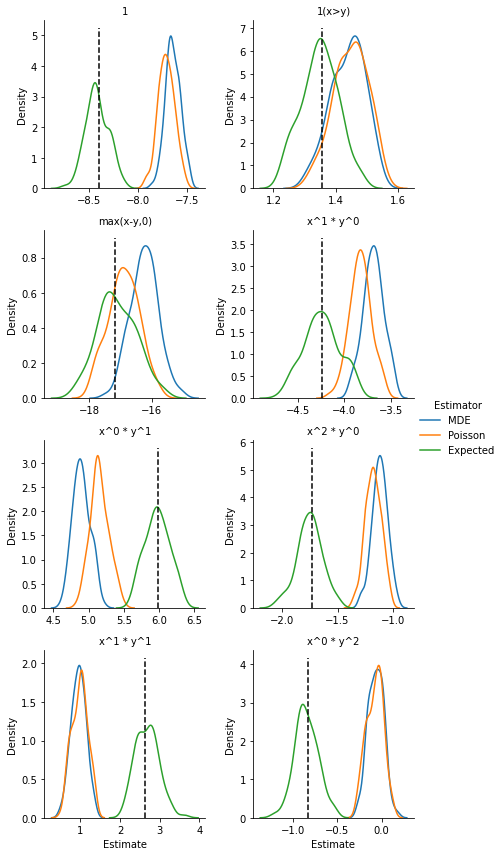

In [ ]:
n_households_obs = n_households_cupid_obs if model_name == "choo_siow_cupid" else None

if plot_simuls:
    plot_simulation_results(model_name, n_households_sim, value_coeff, n_households_obs)

## fitting a nested logit model